# Notebook 1 : Nettoyage et prétraitement des questions

## 1. Libraries & Settings

In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import matplotlib as mlt
import seaborn as sns
from wordcloud import WordCloud
import pickle
nltk.download('punkt', quiet = True)
nltk.download('stopwords',quiet = True)
nltk.download('wordnet', quiet = True)
nltk.download('averaged_perceptron_tagger_eng', quiet = True)
import warnings

# style for all plots
sns.set_style("darkgrid")
sns.set_palette("vlag")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2})
sns.set(rc={
    'axes.labelsize': 10,      
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,    
    'axes.labelcolor': 'gray', 
    'xtick.color': 'gray', 
    'ytick.color': 'gray',
    'axes.titlesize': 12,    
})

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore", category=UserWarning, message=".*token_pattern.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*looks more like a filename.*")

## 2. Load Data

**Columns Overview**
   - **Title:** This column contains the titles of questions. It is a crucial feature since it often summarizes the question.
   - **Body:** This column contains the main content of the questions. Like the title, all 50,000 entries are non-null.
   - **Tags:** This column contains tags associated with each question, and all entries are non-null. These tags typically represent the key topics or technologies related to the question.
   - **Id:** A unique identifier for each question.
   - **Score:** This column represents the score or rating of each question. It contains non-null integer values for all entries, indicating user engagement.
   - **ViewCount:** This column indicates how many times each question has been viewed. It has non-null values for all entries.
   - **FavoriteCount:** This column contains only null values (`NaN`) across the entire dataset.
   - **AnswerCount:** This column contains non-null integer values for all entries and represents the number of answers each question has received.

In [2]:
df = pd.read_csv("C:/Users/Luciana/Documents/GitHub/NLP-Multi-Label-Text-Classification-for-Stack-Overflow-Tag-Prediction/QueryResults2.csv")

# Drop unnecessary columns
df.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount'], inplace=True) # , 'FavoriteCount'

# Sample of the data
#df = df.sample(frac=0.5, random_state=42)
#df.reset_index(drop=True, inplace=True)

print('Data shape:', df.shape)
df.head(1)

Data shape: (10000, 3)


,Title,Body,Tags
0,How to convert Decimal to Double in C#?,"<p>I want to assign the decimal variable <code>trans</code> to the double variable <code>this.Opacity</code>.</p>\n<pre class=""lang-cs prettyprint-override""><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the app it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type decimal to double</p>\n</blockquote>\n",<c#><floating-point><type-conversion><double><decimal>


## 3. Preprocessing

### 3.1 Functions for preprocessing

In [3]:
# Function for cleaning TAGS ---------------------------------------------------------------------
special_words = {'c#', 'c++', 'f#', 'asp.net', 'vb.net', 'node.js', 'objective-c', 'ai'}

# Function for the 'Tags' colum ---------------------------------------------------------------------
def preprocess_tags(tags):
    def clean_word(word):        
        if word in special_words: # Preserve special words exactly
            return word        
        cleaned_word = re.sub(r"[^\w\s\-]", "", word) # Remove unwanted characters except hyphen, apostrophe        
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word) # Remove trailing hyphens or numbers
        return cleaned_word    
        
    words = re.findall(r'(?<=<)(.*?)(?=>)', tags)  # Extract words
    processed_words = [
        clean_word(word) for word in words] # Keep words within length constraints 
    words = [subword for word in processed_words for subword in word.split()]  
    words = [w for w in words if len(w) > 2 or w in special_words] 
    return words

# Function for cleaning BODY & TITLE ---------------------------------------------------------------------
def clean_text(sentence):
    def clean_word(word):
        if word in special_words:  # Preserve special words exactly
            return [word]        
        cleaned_word = re.sub(r"(\'s|\'ve|\'d|\'ll|\'re|\'m|\'t)$", "", word) # Remove common contraction suffixes        
        cleaned_word = re.sub(r"[^\w\s\-]", " ", cleaned_word)  # Replace non-alphanumeric characters (except hyphens) with spaces
        cleaned_word = re.sub(r"^-+", "", cleaned_word)  # Remove leading hyphens
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word)  # Remove trailing hyphens or numbers
        cleaned_word = cleaned_word.strip()
        
        if len(cleaned_word) <= 1 and cleaned_word not in special_words: # remove any single-letter words after cleaning
            return None        
        split_words = re.split(r'[.\-#]', cleaned_word) # Split words like 'this.opacity' into 'this' and 'opacity'        
        split_words = [sub_word for word in split_words for sub_word in word.split() if sub_word] # additional split on spaces in case of unexpected grouping        
        return [w for w in split_words if w] # Remove empty strings from the split result
    
    soup = BeautifulSoup(sentence, "html.parser") # Remove HTML tags and convert to lowercase
    sentence = soup.get_text()
    sentence = sentence.lower()    
    words = sentence.split()     
    words = re.findall(r"\w+[-.#']?\w*|\S+", sentence) # Tokenize words 
    
    processed_words = [clean_word(word) for word in words] # Process and filter words
    filtered_words = [
        word for sublist in processed_words if sublist for word in sublist
        if len(word) > 1  # Exclude single-letter words
        and '_' not in word  # Exclude words with underscores
        and word.isascii()  # Exclude non-ASCII words
        and not any(char.isdigit() for char in word)  ]  # Exclude words with digits
    return filtered_words
    
# STOP WORDS -------------------------------------------------------------------
stop_w = set(stopwords.words('english'))
def stop_word_filter(list_words):
    return [ w for w in list_words if w not in stop_w]

# LEMMA -------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
def lemma_words(list_words):
    return [lemmatizer.lemmatize(w, pos='v') for w in list_words]

# Remove specific words -------------------------------------------------------------------
words_to_exclude = {'however', 'good', 'anyone', 'say', 'problem','better', 'another', 'please', 'etc', 'actually','someone', 'happen', 'ask',  'maybe', 'look', 'little', 'advance',
'need', 'something', 'question', 'example', 'thank', 'also', 'cannot', 'think', 'anything', 'idea', 'thing', 'ideas', 'people', 'basically', 'nice', 'easily', 'feel',
'obviously', 'specifically', 'problem'}
def remove_words(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    tags_to_remove = {'MD', 'CD' } # 'WRB', 'WP$', 'PRP$', 'PDT', 'JJR',  'EX'
    return [ word for word, tag in tagged_tokens
        if tag not in tags_to_remove and word.lower() not in words_to_exclude]

# Preprocessing BODY & TITLE ---------------------------------------------------------------------
def custom_tokenizer(desc_text):
    cleaned = clean_text(desc_text)
    filtered = stop_word_filter(cleaned)
    lemmatized = lemma_words(filtered)
    words_removed = remove_words(lemmatized)
    return words_removed

### 3.2 Apply function

In [4]:
# Apply preprocessing
df['Tags'] = df['Tags'].apply(preprocess_tags)
df['title_bow'] = df['Title'].apply(custom_tokenizer)
df['body_bow'] = df['Body'].apply(custom_tokenizer)

# Combine "Title" and "Body" for the Bag of Words approach
df['combined_text_bow'] = df['title_bow'] + df['body_bow']
df['combined_text_bow'] = df['combined_text_bow'].apply(lambda x: ' '.join(x))
X = df['combined_text_bow']

# Applying
df.drop(columns=['Title', 'Body','title_bow', 'body_bow' ], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(1)

,Tags,combined_text_bow
0,"[c#, floating-point, type-conversion, double, decimal]",convert decimal double c# assign decimal variable trans double variable thisopacity decimal trans thisopacity trans build app give follow error implicitly convert type decimal double


## 4. Exploratory Data Analysis

### 4.1 Length distribution

In [5]:
df['combined_text_bow_list'] = df['combined_text_bow'].apply(lambda x: str(x).split())

df['len_combined_bow'] = df['combined_text_bow_list'].apply(lambda x: len(x))
print('Max length combined_bow_list:', df['len_combined_bow'].max())

df['len_tags'] = df['Tags'].apply(lambda x: len(x))
print('Max length Tags:', df['len_tags'].max())

Max length combined_bow_list: 1722
Max length Tags: 5


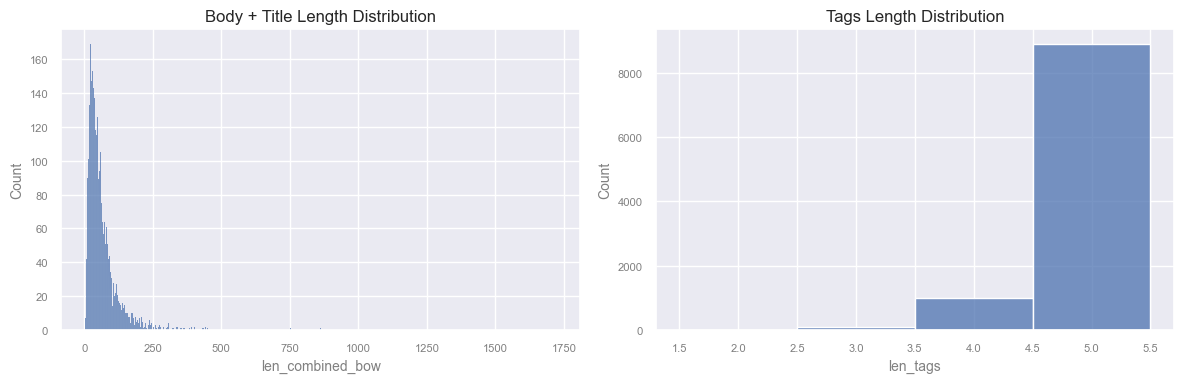

In [6]:
# Viz the distrivution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df, x='len_combined_bow', discrete=True, ax=axes[0])
axes[0].set_title('Body + Title Length Distribution')

sns.histplot(df, x='len_tags', discrete=True, ax=axes[1])
axes[1].set_title('Tags Length Distribution')
plt.tight_layout()
plt.show()

Truncate features to improve model performance

In [7]:
# Truncate the body column to X amount of words
print('Lists > 250 words:', (df['len_combined_bow'] > 250).sum())
#max_lenght_body = 250
#df['body_clean_bow'] = df['body_clean_bow'].apply(lambda x: x[:max_lenght_body])

Lists > 250 words: 200


### 4.2 Word analysis

#### 4.2.1 Word Frequency

In [8]:
# Flatten the list of words 
body_bow_words = [word for tokens in df['combined_text_bow_list'] for word in tokens]
tags_words = [word for tokens in df['Tags'] for word in tokens]
print('Unique words in Combined Text BoW:', len(set(body_bow_words)))
print('Unique words in Tags:', len(set(tags_words)))

# Count the frequency of each word - Creates a dictionary
body_bow_word_counts = Counter(body_bow_words)
tags_word_counts = Counter(tags_words)

# Transformin the dic in df
body_bow_df = pd.DataFrame(body_bow_word_counts.items(), columns=['word', 'freq'])
tags_df = pd.DataFrame(tags_word_counts.items(), columns=['word', 'freq'])

Unique words in Combined Text BoW: 47924
Unique words in Tags: 6255


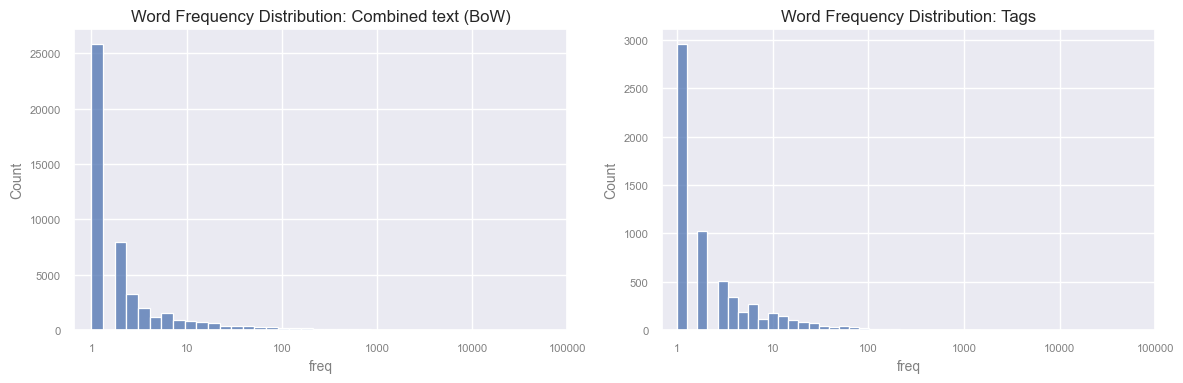

In [9]:
# Plot the distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(body_bow_df['freq'], bins=30, ax=axes[0], log_scale=True,)
axes[0].xaxis.set_major_formatter(mlt.ticker.ScalarFormatter())
axes[0].set_xticks([1, 10, 100, 1000, 10000, 100000])
axes[0].set_title('Word Frequency Distribution: Combined text (BoW)')

sns.histplot(tags_df['freq'], bins=30, ax=axes[1], log_scale=True,)
axes[1].xaxis.set_major_formatter(mlt.ticker.ScalarFormatter())
axes[1].set_xticks([1, 10, 100, 1000, 10000, 100000])
axes[1].set_title('Word Frequency Distribution: Tags')
plt.tight_layout()

#### 4.2.2 Word Cloud

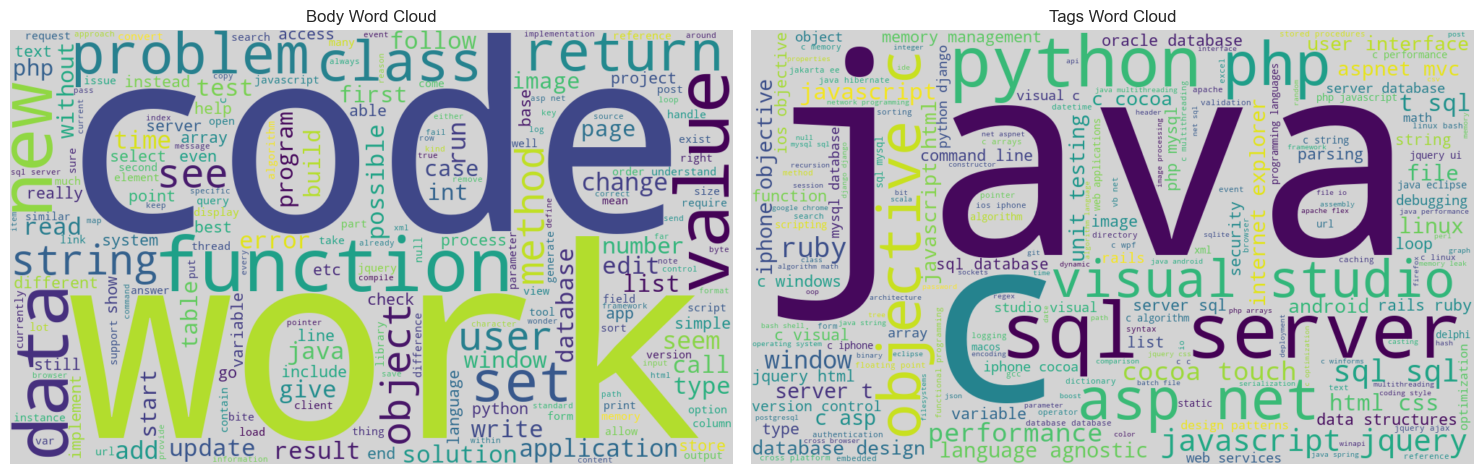

In [10]:
# Create word clouds for body_bow_words and tags_words
str_body_bow = ' '.join(body_bow_words)
str_tags_bow = ' '.join(tags_words)

fig, axes = plt.subplots(1, 2, figsize=(15, 7), )
wc_body = WordCloud(width=1000, height=600, background_color='lightgray').generate(str_body_bow)
axes[0].imshow(wc_body, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Body Word Cloud")

wc_tags = WordCloud(width=1000, height=600, background_color='lightgray').generate(str_tags_bow)
axes[1].imshow(wc_tags, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Tags Word Cloud")
plt.tight_layout()

#### 4.2.3 Most frequent words - Before Vectorization

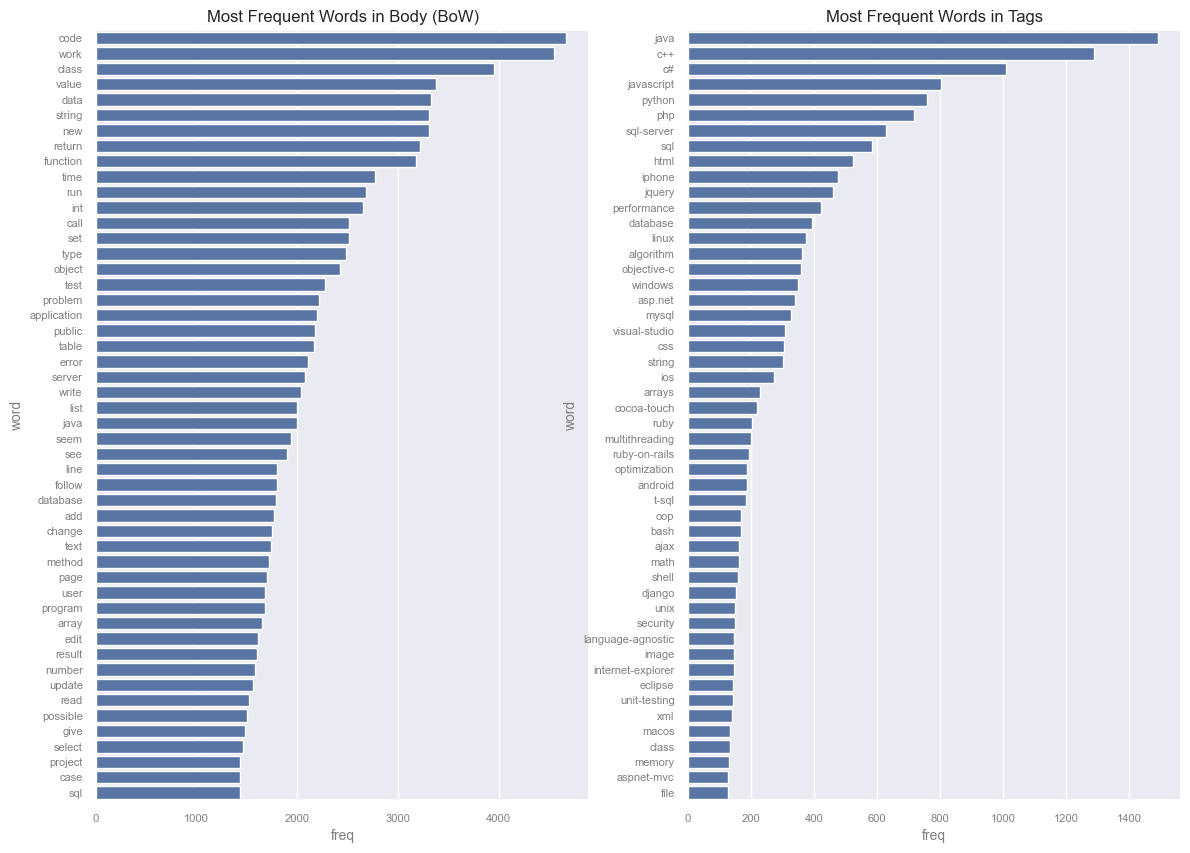

In [11]:
# Get the top X most frequent words
top_body_bow_df = body_bow_df.nlargest(50, 'freq')
top_tags_df = tags_df.nlargest(50, 'freq')

# Plot the most frequent words
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
sns.barplot(top_body_bow_df, x='freq', y='word', ax=axes[0])
axes[0].set_title('Most Frequent Words in Body (BoW)');

sns.barplot(top_tags_df,x='freq', y='word', ax=axes[1])
axes[1].set_title('Most Frequent Words in Tags');

## 5. Multi Label Binarizer

In [12]:
# Initialize and fit-transform the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(df['Tags']), columns=mlb.classes_)
top_tags = y.sum().sort_values(ascending=False).head(100).index
y_top_tags = y[top_tags]
y_top_tags = y_top_tags[y_top_tags.sum(axis=1) > 0]  # Remove rows with none of the 100 top tags
X_filtered = X.loc[y_top_tags.index]   # Removing same rows from the X
y = y_top_tags
y.reset_index(drop=True, inplace=True)
X_filtered.reset_index(drop=True, inplace=True)
print(top_tags)

Index(['java', 'c++', 'c#', 'javascript', 'python', 'php', 'sql', 'html',
       'iphone', 'jquery', 'sql-server', 'performance', 'database', 'linux',
       'algorithm', 'objective-c', 'windows', 'asp.net', 'mysql', 'css',
       'string', 'ios', 'visual-studio', 'arrays', 'cocoa-touch', 'ruby',
       'multithreading', 'optimization', 'android', 't-sql', 'ruby-on-rails',
       'oop', 'bash', 'ajax', 'math', 'shell', 'django', 'unix', 'security',
       'language-agnostic', 'image', 'unit-testing', 'xml', 'macos', 'class',
       'eclipse', 'memory', 'file', 'user-interface', 'database-design',
       'parsing', 'memory-management', 'aspnet-mvc', 'oracle-database',
       'debugging', 'internet-explorer', 'data-structures', 'git', 'cocoa',
       'pointers', 'list', 'gcc', 'regex', 'scripting', 'hibernate',
       'datetime', 'perl', 'stl', 'wpf', 'function', 'sorting', 'svn', 'xcode',
       'testing', 'version-control', 'http', 'variables', 'inheritance', 'jpa',
       'dictionary'

## 6. Split Train/Test

In [13]:
# Split the dfs
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)
print('y Train Shape:', y_train.shape)
print('y Test Shape:', y_test.shape)

# Save the target variables
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

X Train Shape: (7596,)
X Test Shape: (1900,)
y Train Shape: (7596, 100)
y Test Shape: (1900, 100)


## 7. TF-IDF

#### Understanding `max_df` and `min_df`

1. **`max_df`**:
   - This parameter specifies the maximum document frequency for words. Words that appear in more than `max_df` proportion of the documents will be ignored.
   - Example:
     - **0.5**: Ignore terms that appear in more than 50% of the documents.     
     - **1.0**: This means no limit, and all terms will be included.

2. **`min_df`**:
   - This parameter specifies the minimum document frequency for words. Words that appear in fewer than `min_df` documents will be ignored.
   - Example:   
     - **2**: Ignore terms that appear in only two documents.
     - **0.01**: Ignore terms that appear in less than 1% of the documents.

### 7.1 TF-IDF Vectorizer

In [14]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,  max_features=10000,  min_df=5, max_df=0.9, ngram_range=(1, 2), stop_words=None, lowercase=False, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

features_names_tfidf = tfidf.get_feature_names_out() 

print('Vocabulary size:', len(tfidf.vocabulary_))
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

# Saving matrices
with open('features_names_tfidf.pkl', 'wb') as f:
    pickle.dump(features_names_tfidf, f)
with open('vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('X_train_tfidf.pkl', 'wb') as f:
    pickle.dump(X_train_tfidf, f)
with open('X_test_tfidf.pkl', 'wb') as f:
    pickle.dump(X_test_tfidf, f)

Vocabulary size: 10000
Shape of X_train_tfidf: (7596, 10000)
Shape of X_test_tfidf: (1900, 10000)


### 7.2 Analysing results

#### 7.2.1 Top Features by frequency

In [15]:
# Sum the TF-IDF scores across all documents in the training set
tfidf_scores_sum = np.array(X_train_tfidf.sum(axis=0)).flatten()

# Combine feature names and their summed scores
features_scores = zip(tfidf_scores_sum, features_names_tfidf)

# Sort features by their total TF-IDF scores
sorted_features = sorted(features_scores, reverse=True)

# Display the top N most important features
top_n = 20 
print(f"Top {top_n} features by importance (global):")
for score, feature in sorted_features[:top_n]:
    print(f"{feature}: {score}")

Top 20 features by importance (global):
code: 133.75431809260778
work: 132.26420404089677
class: 116.05387667268998
string: 112.67192827863819
function: 103.13312487147988
value: 102.38508252612728
new: 101.67266252579377
data: 99.88054784124245
return: 94.82559514293408
java: 93.17816557443763
run: 92.89966213136347
set: 91.2026345313304
time: 90.81927049292293
object: 86.84199190806982
application: 86.57040551485085
type: 83.3452110079698
call: 82.56776751184061
server: 81.73403031331407
write: 81.07828659941606
seem: 80.09619891284359


#### 7.2.2 Ckeck the mapping of tokens to features names

In [17]:
vocabulary = tfidf.get_feature_names_out()
index = vocabulary.tolist().index('c#')
print(f"Index of 'c#': {index}, Term: {vocabulary[index]}")

Index of 'c#': 939, Term: c#


In [23]:
doc_index = 1

# Original document at index 1
original_doc = X_train[doc_index]
print(f"Original Document (index {doc_index}):\n", original_doc)

# Tokenized version of the document
tokenized_doc = custom_tokenizer(original_doc)
print(f"Tokenized Document (index {doc_index}):\n", tokenized_doc)

# TF-IDF transformation
transformed_doc = X_train_tfidf[doc_index]

# iterating over the TF-IDF features
for i in transformed_doc.indices:
    print(f"Feature Index: {i}, Feature Name: '{features_names_tfidf[i]}', TF-IDF Score: {transformed_doc.data[transformed_doc.indices.tolist().index(i)]}")

Original Document (index 1):
 calculate relative time c# give specific datetime value display relative time hours ago days ago month ago
Tokenized Document (index 1):
 ['calculate', 'relative', 'time', 'c#', 'give', 'specific', 'datetime', 'value', 'display', 'relative', 'time', 'hours', 'ago', 'days', 'ago', 'month', 'ago']
Feature Index: 2147, Feature Name: 'date', TF-IDF Score: 0.21315446982826008
Feature Index: 457, Feature Name: 'arithmetic', TF-IDF Score: 0.3183238755421599
Feature Index: 9194, Feature Name: 'unix', TF-IDF Score: 0.2134183228151112
Feature Index: 7765, Feature Name: 'shell', TF-IDF Score: 0.19969488067567362
Feature Index: 7404, Feature Name: 'script', TF-IDF Score: 0.14510074072877888
Feature Index: 1827, Feature Name: 'control', TF-IDF Score: 0.0961628999928232
Feature Index: 3010, Feature Name: 'execution', TF-IDF Score: 0.12403890210037363
Feature Index: 8784, Feature Name: 'third', TF-IDF Score: 0.12943388695454164
Feature Index: 6010, Feature Name: 'party',

In [33]:
for token in tokenized_doc:
    if 'c#' in token:
        print(f"Token '{token}' maps to vocabulary.")

Token 'c#' maps to vocabulary.


In [28]:
tokenized_doc = custom_tokenizer(original_doc)
for token in tokenized_doc:
    if token in vocabulary:
        print(f"Token: '{token}' maps to vocabulary.")
    else:
        print(f"Token: '{token}' does NOT map to vocabulary.")

Token: 'calculate' maps to vocabulary.
Token: 'relative' maps to vocabulary.
Token: 'time' maps to vocabulary.
Token: 'c#' maps to vocabulary.
Token: 'give' maps to vocabulary.
Token: 'specific' maps to vocabulary.
Token: 'datetime' maps to vocabulary.
Token: 'value' maps to vocabulary.
Token: 'display' maps to vocabulary.
Token: 'relative' maps to vocabulary.
Token: 'time' maps to vocabulary.
Token: 'hours' maps to vocabulary.
Token: 'ago' maps to vocabulary.
Token: 'days' maps to vocabulary.
Token: 'ago' maps to vocabulary.
Token: 'month' maps to vocabulary.
Token: 'ago' maps to vocabulary.


In [31]:
print("Features names:")
for feature in features_names_tfidf:
    if 'c#' in feature:
        print(feature)

Features names:
application c#
c#
c# application
c# best
c# c#
c# class
c# code
c# java
c# net
c# project
c# read
c# string
c# windows
c# winforms
c# wpf
class c#
code c#
come c#
function c#
java c#
language c#
new c#
program c#
server c#
studio c#
type c#
work c#
write c#


In [34]:
c_sharp_frequency = (X_train.str.contains("c#").sum())
print(f"Frequency of 'c#' in X_train: {c_sharp_frequency}")

Frequency of 'c#' in X_train: 475


#### 7.2.3 Checking the a word 'python'

In [29]:
python_index = tfidf.vocabulary_.get("python")
print("Index of 'python' in the vocabulary:", python_index)

python_values_train = X_train_tfidf[:, python_index].toarray().flatten()
print("TF-IDF values for 'python' in X_train:", python_values_train)

print("Shape of python_values_train:", python_values_train.shape) # nombre of rows in X_train_tfidf

rows_with_python_train = np.where(python_values_train > 0)[0]
print("Rows in X_train_tfidf with 'python':", len(rows_with_python_train))

Index of 'python' in the vocabulary: 6674
TF-IDF values for 'python' in X_train: [0. 0. 0. ... 0. 0. 0.]
Shape of python_values_train: (7596,)
Rows in X_train with 'python': 490


#### 7.2.4 Word cloud of Features names by frequency

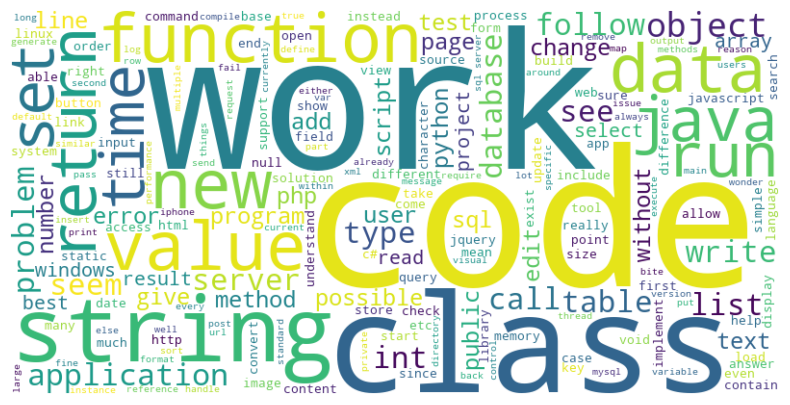

In [25]:
# Sum the TF-IDF values across all documents (rows)
word_tfidf_sum = np.array(X_train_tfidf.sum(axis=0)).flatten()

# Create a dictionary mapping each feature (word) to its summed TF-IDF weight
tfidf_dict = dict(zip(features_names_tfidf, word_tfidf_sum))

# Sort the dictionary by summed TF-IDF values in descending order
sorted_tfidf_dict = dict(sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 8. Countvectorizer

### 8.1 Countvectorizer params

In [33]:
cv = CountVectorizer(tokenizer=custom_tokenizer,  max_features=10000,  min_df=5, max_df=0.9, ngram_range=(1, 2), stop_words=None, lowercase=False)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

features_names_cv = cv.get_feature_names_out()

print('Vocabulary size:', len(cv.vocabulary_))
print("Shape of X_train_cv:", X_train_cv.shape)
print("Shape of X_test_cv:", X_test_cv.shape)

# Saving sparse matrices
with open('features_names_cv.pkl', 'wb') as f:
    pickle.dump(features_names_cv, f)
with open('vectorizer_cv.pkl', 'wb') as f:
    pickle.dump(cv, f)
with open('X_train_cv.pkl', 'wb') as f:
    pickle.dump(X_train_cv, f)
with open('X_test_cv.pkl', 'wb') as f:
    pickle.dump(X_test_cv, f)

Vocabulary size: 10000
Shape of X_train_cv: (7596, 10000)
Shape of X_test_cv: (1900, 10000)


### 8.2 Analysing results

#### 8.2.1 Top Features by frequency

In [34]:
# Sum the TF-IDF scores across all documents in the training set
cv_scores_sum = np.array(X_train_cv.sum(axis=0)).flatten()

# Combine feature names and their summed scores
features_scores = zip(cv_scores_sum, features_names_cv)

# Sort features by their total TF-IDF scores
sorted_features = sorted(features_scores, reverse=True)

# Display the top N most important features
top_n = 20  
print(f"Top {top_n} features by importance (global):")
for score, feature in sorted_features[:top_n]:
    print(f"{feature}: {score}")

Top 20 features by importance (global):
code: 3483
work: 3424
class: 3159
new: 2615
string: 2604
value: 2568
data: 2509
return: 2471
function: 2355
time: 2047
run: 2011
int: 2007
set: 1960
call: 1955
object: 1885
type: 1874
public: 1753
table: 1751
application: 1679
test: 1670


#### 8.2.2 Word Cloud by frequency

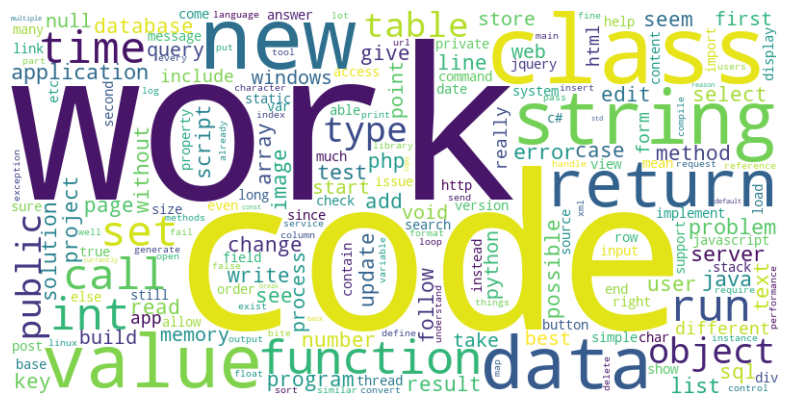

In [35]:
# Sum the TF-IDF values across all documents (rows)
word_cv_sum = np.array(X_train_cv.sum(axis=0)).flatten()

# Create a dictionary mapping each feature (word) to its summed TF-IDF weight
cv_dict = dict(zip(features_names_cv, word_cv_sum))

# Sort the dictionary by summed TF-IDF values in descending order
sorted_cv_dict = dict(sorted(cv_dict.items(), key=lambda item: item[1], reverse=True))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cv_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()